# CMIP6 Convert Units

**Following steps are included in this script:**

1. Load netCDF files
2. Convert Units to Specified Format
3. Save and replace netcdf files

In [1]:
# ========== Packages ==========
import sys
import os
import xarray as xr
import dask
from dask.diagnostics import ProgressBar
import importlib
import copy

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as ld
import save_data_as_nc as sd
from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

### Functions

In [10]:
def create_log(ds, name, var, old_unit):

        if 'log' in ds.attrs:
            log_old = ds.attrs['log']
            ds.attrs['log'] = f'Unit of {var} converted from {old_unit} to {ds[var].units}. // {log_old}'
        else:
            ds.attrs['log'] = f'Unit of {var} converted from {old_unit} to {ds[var].units}.'

        print(f"Unit of {var} for model {name} converted from {old_unit} to {ds[var].units}.")
        return ds

In [11]:
def set_units(ds_dict, conv_units):
    """
     Convert units for specified variables
    """

    ds_dict_copy = copy.deepcopy(ds_dict)  
    
    for i, (name, ds) in enumerate(ds_dict_copy.items()):

        for var in list(conv_units.keys()):

            if var in ds.variables:
                old_unit = ds[var].units
                
                if conv_units[var] == ds[var].units:
                    print(f'Unit {var} for model {name} already in the requested format')
                    
                elif var == 'lai':
                    # Keep existing attributes and only modify the units attribute
                    attrs = ds[var].attrs
                    attrs['units'] = conv_units[var]
                    attrs['equation'] = 'leaf area / ground area'
                    ds[var].attrs = attrs
                    ds = create_log(ds, name, var, old_unit)


                elif conv_units[var] == 'gC/m²/day':
                    if ds[var].units == 'kg/m²/s' or 'kg m-2 s-1':
                    
                        # Keep existing attributes and only modify the units attribute
                        attrs = ds[var].attrs
                        attrs['units'] = conv_units[var]
                        ds[var] = ds[var] * 1000 * 60 * 60 * 24 
                        ds[var].attrs = attrs
                        ds = create_log(ds, name, var, old_unit)
                        
                elif conv_units[var] == 'mm/day':
                    if ds[var].units == 'kg/m²/s' or ds[var].units =='kg m-2 s-1':
    
                        # Keep existing attributes and only modify the units attribute
                        attrs = ds[var].attrs
                        attrs['units'] = conv_units[var]
                        ds[var] = ds[var] * 60 * 60 * 24 
                        ds[var].attrs = attrs
                        ds = create_log(ds, name, var, old_unit)
                
                elif conv_units[var] == 'hPa':
                    if ds[var].units == 'Pa':
    
                        # Keep existing attributes and only modify the units attribute
                        attrs = ds[var].attrs
                        attrs['units'] = conv_units[var]
                        ds[var] = ds[var] / 100 
                        ds[var].attrs = attrs
                        ds = create_log(ds, name, var, old_unit)
                        
                elif conv_units[var] == 'ppm':
                    if ds[var].units == 'kg':
                        # Keep existing attributes and only modify the units attribute
                        attrs = ds[var].attrs
                        attrs['units'] = conv_units[var]
                        attrs['long_name'] = 'CO2 concentration'
                        # Constants
                        molar_mass_co2 = 44.01  # Molar mass of CO2 in grams per mole (g/mol)
                        moles_of_air = 2.13e20  # Volume of the atmosphere in moles (may vary, check CMIP6 documentation)
                        # Convert co2mass from kg to moles
                        ds[var] = ((ds[var] / molar_mass_co2) / moles_of_air) * 1e6
                        ds[var].attrs = attrs
                        ds = create_log(ds, name, var, old_unit)
                            
                elif conv_units[var] == '°C':
                    if ds[var].units == 'K':
                        # Keep existing attributes and only modify the units attribute
                        attrs = ds[var].attrs
                        attrs['units'] = conv_units[var]
                        # Convert co2mass from kg to moles
                        ds[var] = ds[var] - 273.15
                        ds[var].attrs = attrs
                        ds = create_log(ds, name, var, old_unit)
                
                elif conv_units[var] == 'mm':
                    if ds[var].units == 'kg/m²':
                        # Keep existing attributes and only modify the units attribute
                        attrs = ds[var].attrs
                        attrs['units'] = conv_units[var]
                        # Convert co2mass from kg to moles
                        ds[var] = ds[var] / 1e3  # This now represents mm of water
                        ds[var].attrs = attrs
                        ds = create_log(ds, name, var, old_unit)

                else: 
                    raise ValueError(f"No unit conversion for variable '{var}' specified.")

            else:
                print(f"No variable '{var}' in ds_dict.")
        
        ds_dict_copy[name] = ds
                
    return ds_dict_copy

### 1. Load netCDF files

In [4]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['ssp370']
temp_res = 'month'
models = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'NorESM2-MM', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'MPI-ESM1-2-LR', 'TaiESM1']
variables=['evspsbl', 'tran', 'gpp', 'tas', 'pr', 'lai', 'mrso', 'mrro'] 
           
# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(ld.load_multiple_models_and_experiments(BASE_DIR, data_state, data_product, experiments, temp_res, models, variables))[0]

No file found for variable 'gpp' in model 'CAMS-CSM1-0'.
Model 'CAMS-CSM1-0' is missing variables: gpp
No file found for variable 'gpp' in model 'GFDL-ESM4'.
Model 'GFDL-ESM4' is missing variables: gpp
[########################################] | 100% Completed | 34.67 s


['ssp370']


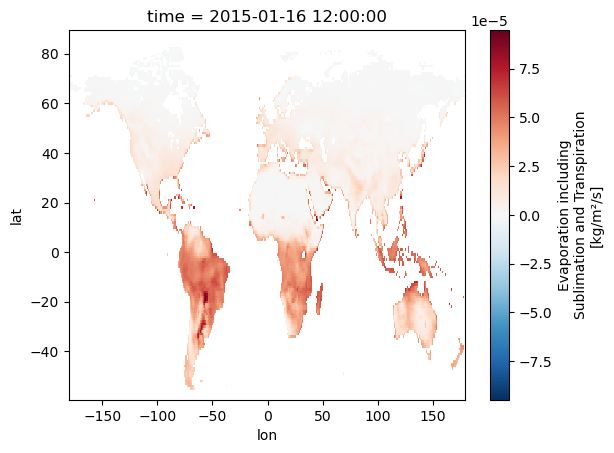

In [5]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[list(ds_dict.keys())[0]][models[0]][variables[0]].isel(time=0).plot()

### 2. Convert units

In [6]:
# ========== Convert units ============

# New unit conversion must be defined in function
conv_units = {'pr': 'mm/day',
            'evspsbl': 'mm/day',
            'mrro': 'mm/day', 
            'gpp': 'gC/m²/day', 
            'tran': 'mm/day',
            'lai': '',
            'mrso': 'mm',
            #'vpd': 'hPa',
            'tas': '°C'
            }

In [7]:
ds_dict_new_units = {}
ds_dict_new_units = set_units(ds_dict[experiments[0]], conv_units)

Unit of pr converted from kg/m²/s to mm/day.
Unit of evspsbl converted from kg/m²/s to mm/day.
Unit of mrro converted from kg/m²/s to mm/day.
Unit of gpp converted from kg/m²/s to gC/m²/day.
Unit of tran converted from kg/m²/s to mm/day.
Unit already in the requested format
Unit of mrso converted from kg/m² to mm.
Unit of tas converted from K to °C.
Unit of pr converted from kg/m²/s to mm/day.
Unit of evspsbl converted from kg/m²/s to mm/day.
Unit of mrro converted from kg/m²/s to mm/day.
No variable 'gpp' in ds_dict.
Unit of tran converted from kg/m²/s to mm/day.
Unit already in the requested format
Unit of mrso converted from kg/m² to mm.
Unit of tas converted from K to °C.
Unit of pr converted from kg/m²/s to mm/day.
Unit of evspsbl converted from kg/m²/s to mm/day.
Unit of mrro converted from kg/m²/s to mm/day.
Unit of gpp converted from kg/m²/s to gC/m²/day.
Unit of tran converted from kg/m²/s to mm/day.
Unit already in the requested format
Unit of mrso converted from kg/m² to mm.

['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'NorESM2-MM', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'MPI-ESM1-2-LR', 'TaiESM1']


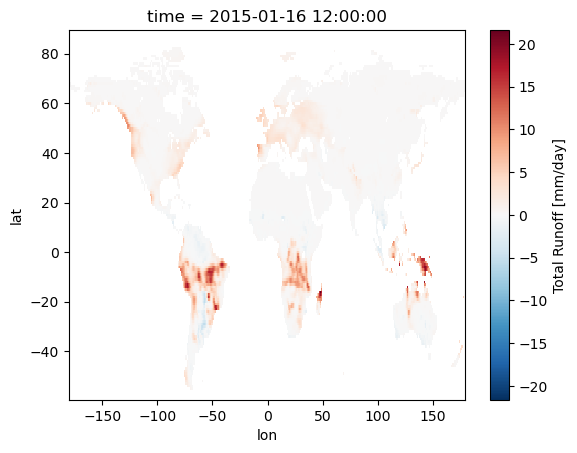

In [22]:
# ========= Have a look into the dictionary =======
print(list(ds_dict_new_units.keys()))
ds_dict_new_units[models[0]][variables[7]].isel(time=0).plot()

### 3. Save and replace netcdf files

In [23]:
# =========== Store file and remove any former one ==========
# Base directory
data_path = f'{data_state}/{data_product}/{experiments[0]}/{temp_res}/'
file_path = os.path.join(BASE_DIR, data_path)
print(file_path)

/work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/


In [24]:
sd.save_files(ds_dict_new_units, file_path)

File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/evspsbl/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/evspsbl/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tran/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tran/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/gpp/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/gpp/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tas/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tas/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/pr/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g